## Homework 05

In [1]:
import os
import sys
import json
import numpy as np
import torch
torch.set_default_dtype(torch.float64)

import sklearn
from sklearn.datasets import make_circles
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp

import matplotlib.pyplot as plt
import seaborn as sns

Let's consider a binary classification problem on Circles dataset. The input is two-dimensional and the response is binary (0,1).

We observe $1000$ points $x$ from this dataset and their labels $y$:

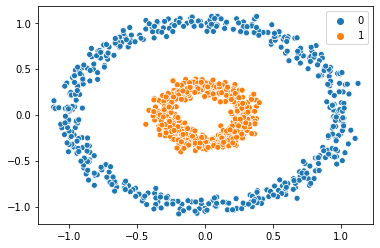

In [2]:
x, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double()

def scatterplot(x, y):
    colors = np.array(['0', '1'])
    sns.scatterplot(x[:, 0], x[:, 1], hue=colors[y.int()])
    
scatterplot(x, y)

### scikit-learn GaussianProcessClassifier

1. `GaussianProcessClassifier` from scikit-learn library [1] approximates the non-Gaussian posterior by a Gaussian using Laplace approximation. Define an RBF kernel `gp_sklearn.kernels.RBF` with lenghtscale parameter $=1$ and fit a Gaussian Process classifier to the observed data (x,y).

2. Use `plot_sklearn_predictions` function defined below to plot the posterior predictive mean function over a finite grid of points. You should pass as inputs the learned GP classifier `sklearn_gp_classifier`, the observed points `x` and their labels `y`.

In [3]:
def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
                         np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid

def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
    x0, x1, x_grid = meshgrid(x, 30) 

    preds = sklearn_gp_classifier.predict_proba(x_grid)
    preds_0 = preds[:,0].reshape(x0.shape)
    preds_1 = preds[:,1].reshape(x0.shape)

    plt.figure(figsize=(10,6))
    plt.contourf(x0, x1, preds_0, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.contourf(x0, x1, preds_1, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)

    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

### Pyro classification with HMC inference 
Consider the following generative model

\begin{align*}
y_n| p_n &\sim \text{Bernoulli}(p_n) \qquad n=1,\ldots,N\\
\mu &\sim \mathcal{N}(0,1)\\
\sigma, l &\sim \text{LogNormal}(0,1)\\
\text{logit}(\mathbf{p})|\mu,\sigma,l &\sim \mathcal{GP}(\mu, K_{\sigma,l}(x_n))\\
\end{align*}

We model the binary response variable with a Bernoulli likelihood. The logit of the probability is a Gaussian Process with predictors $x_n$ and kernel matrix $K_{\sigma,l}$, parametrized by variance $\sigma$ and lengthscale $l$.

We want to solve this binary classification problem by means of HMC inference, so we need to reparametrize the multivariate Gaussian $\mathcal{GP}(\mu, K_{\sigma,l}(x_n))$ in order to ensure computational efficiency. Specifically, we model the logit probability as 

$$\text{logit}(\mathbf{p}) = \mu \cdot \mathbf{1}_N + \eta \cdot L,$$

where $L$ is the Cholesky factor of $K_{\sigma,l}$ and $\eta_n\sim\mathcal{N}(0,1)$. This relationship is implemented by the `get_logits` function below.


In [4]:
def get_logits(x, mu, sigma, l, eta):
    kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma), lengthscale=torch.tensor(l))
    K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
    L = K.cholesky()
    return mu+torch.mv(L,eta)

3. Write a pyro model `gp_classifier(x,y)` that implements the reparametrized generative model, using `get_logits` function and `pyro.plate` on independent observations $y_n$.

4. Use pyro `NUTS` on the `gp_classifier` model to infer the posterior distribution of its parameters. Set `num_samples=10` and `warmup_steps=50`. Then extract the posterior samples using pyro `.get_samples()` and print the keys of this dictionary using `.keys()` method.

The `posterior_predictive` function below outputs the prediction corresponding to the $i$-th sample from the posterior distribution. `plot_pyro_predictions` calls this method to compute the average prediction on each input point and plots the posterior predictive mean function over a finite grid of points. 

In [5]:
def posterior_predictive(samples, i, x, x_grid):
    kernel = gp.kernels.RBF(input_dim=2, variance=samples['sigma'][i], 
                            lengthscale=samples['l'][i]) 
    N_grid = x_grid.shape[0]
    
    y = get_logits(x, samples['mu'][i], samples['sigma'][i], 
                   samples['l'][i],  samples['eta'][i])
        
    with torch.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)
        
    yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()    
    return yhat.sigmoid().numpy()

def plot_pyro_predictions(posterior_samples, x):

    n_samples = posterior_samples['sigma'].shape[0]
    x0, x1, x_grid = meshgrid(x, 30) 
    x_grid = torch.from_numpy(x_grid)
    preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) 
                      for i in range(n_samples)])

    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101, 
                 cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

5. Pass the learned posterior samples obtained from NUTS inference and the set of training points `x` to `plot_pyro_predictions` and plot the posterior predictive mean.  

## References

[1] [sklearn GP classifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)

[2] [pyro GPs](https://pyro.ai/examples/gp.html)